In [19]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime, Stream
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

In [55]:
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_beam_wander_data import __load_beam_wander_data

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [5]:
config = {}

config['cam'] = ""

config['path_to_data'] = data_path+"ids/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

## experiment 1
# config['date1'] = "2024-01-29"
# config['date2'] = "2024-02-05"

## experiment 2
# config['date1'] = "2024-02-15"
# config['date2'] = "2024-02-23"

## experiment 3
# config['date1'] = "2024-03-09"
# config['date2'] = "2024-04-09"

## experiment 4
config['date1'] = "2024-03-09"
config['date2'] = "2024-05-21"

# ## experiment 5
# config['date1'] = "2024-05-22"
# config['date2'] = "2024-06-12"

## experiment 6
# after switch to ids04 !
# config['date1'] = "2024-08-06"
# config['date2'] = "2024-08-13"


In [73]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [73]:
# mlti = DataFrame()
# mlti['t1'] = mltiU_t1
# mlti['t2'] = mltiU_t2

# opath = data_path+"manuscripts/manuscript_romy_drifts/data/"
# mlti.to_pickle(opath+f"bw_ru_longterm_mlti.pkl")

In [8]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [10]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], config['cam'])

2024-03-09
2024-03-10
2024-03-11
2024-03-12
2024-03-13
 -> error for 20240313.pkl
2024-03-14
 -> error for 20240314.pkl
2024-03-15
2024-03-16
2024-03-17
2024-03-18
2024-03-19
2024-03-20
 -> error for 20240320.pkl
2024-03-21
2024-03-22
2024-03-23
2024-03-24
2024-03-25
2024-03-26
2024-03-27
2024-03-28
2024-03-29
2024-03-30
2024-03-31
2024-04-01
2024-04-02
2024-04-03
2024-04-04
2024-04-05
2024-04-06
2024-04-07
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-13
2024-04-14
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19
2024-04-20
2024-04-21
2024-04-22
2024-04-23
2024-04-24
2024-04-25
2024-04-26
2024-04-27
2024-04-28
2024-04-29
2024-04-30
2024-05-01
2024-05-02
2024-05-03
2024-05-04
2024-05-05
2024-05-06
2024-05-07
2024-05-08
2024-05-09
2024-05-10
2024-05-11
2024-05-12
2024-05-13
2024-05-14
2024-05-15
2024-05-16
2024-05-17
2024-05-18
2024-05-19
2024-05-20
2024-05-21


### Remove MLTI times

In [11]:

# add utc object
df['time_utc'] = [UTCDateTime(tl) for tl in df.time]


# pixel to length
if config['date1'] > "2024-08-01":
    conversion_factor = 5.3e-3 # mm / pixel
else:
    conversion_factor = 1.67e-3 # mm / pixel

keys_to_convert = ["y_idx", "x_idx", "y", "x"]

for k in keys_to_convert:
    df[k] *= conversion_factor

# turn times with MLTI to NaN
df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)


### Remove artefacts

In [12]:
# remove corrupt values
df = df[df['y_sig_var'] != np.inf]

# when intensity is super low, there is a black image
df = df[df['amp'] > 20]

# when intensity is super high or saturated, there is likely a MLTI boost
df = df[df['amp'] < 255]

### Load Maintenance Log

In [13]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['date1'], config['date2'], archive_path)
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


In [75]:
# lxx = DataFrame()
# lxx['t1'] = lxx_t1
# lxx['t2'] = lxx_t2

# opath = data_path+"manuscripts/manuscript_romy_drifts/data/"
# lxx.to_pickle(opath+f"bw_ru_longterm_lxx.pkl")

### Plotting

In [14]:
from functions.reduce import __reduce

In [15]:
df['x_um_rel'] = __reduce(df.x, 10) * 1e3
df['y_um_rel'] = __reduce(df.y, 10) * 1e3

In [74]:
# opath = data_path+"manuscripts/manuscript_romy_drifts/data/"
# df.to_pickle(opath+f"bw_ru_longterm.pkl")

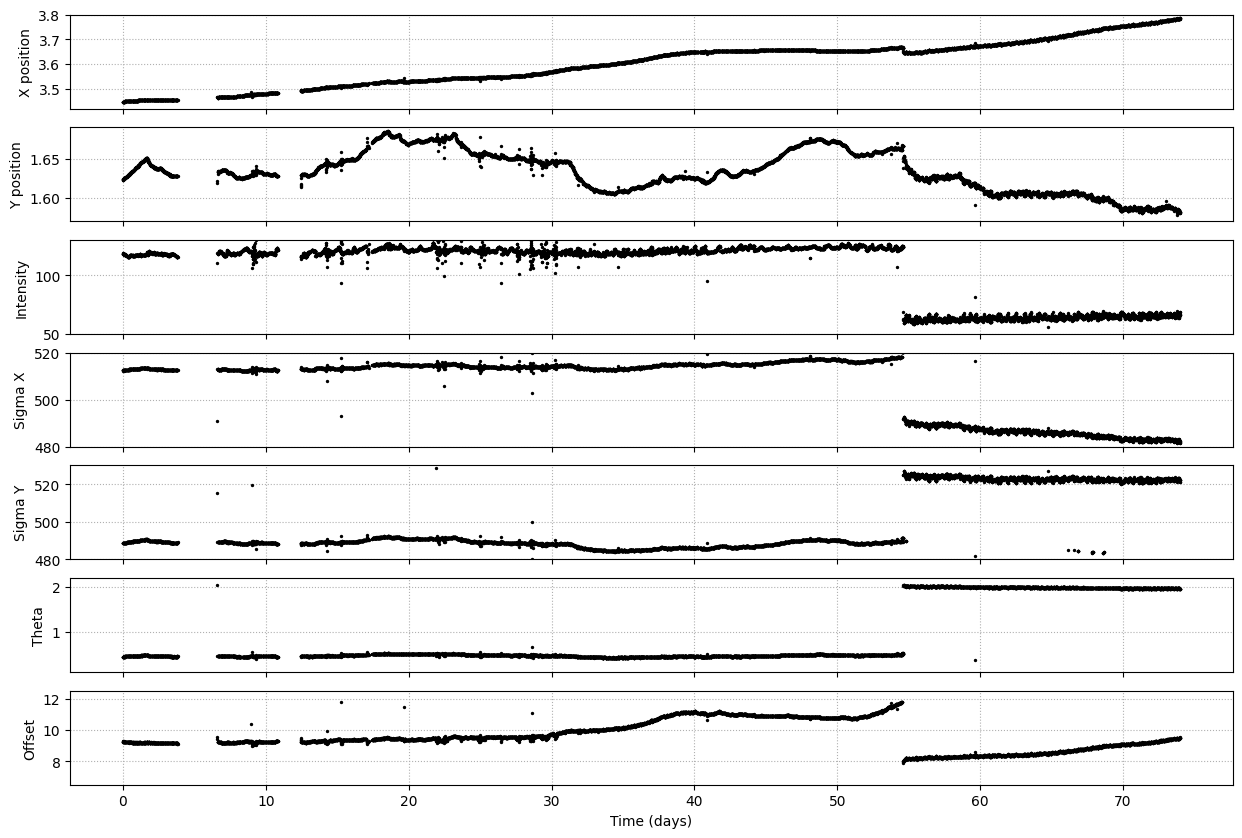

In [17]:
def __makeplot():

    Nrow, Ncol = 7, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    # ax[0].fill_between(df.time_sec*tscale, df.x-df.x_var, df.x+df.x_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[0].scatter(df.time_sec*tscale, df.x, s=size, zorder=2, color="k")
    ax[0].set_ylim(3.42, 3.8)
    ax[0].set_ylabel("X position")

    # ax[1].fill_between(df.time_sec*tscale, df.y-df.y_var, df.y+df.y_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[1].scatter(df.time_sec*tscale, df.y, s=size, zorder=2, color="k")
    ax[1].set_ylim(1.57, 1.69)
    ax[1].set_ylabel("Y position")

    # ax[2].fill_between(df.time_sec*tscale, df.amp-df.amp_var, df.amp+df.amp_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[2].scatter(df.time_sec*tscale, df.amp, s=size, zorder=2, color="k")
    ax[2].set_ylim(50, 130)
    ax[2].set_ylabel("Intensity")

    # ax[3].fill_between(df.time_sec*tscale, df.x_sig-df.x_sig_var, df.x_sig+df.x_sig_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[3].scatter(df.time_sec*tscale, df.x_sig, s=size, zorder=2, color="k")
    ax[3].set_ylim(480, 520)
    ax[3].set_ylabel("Sigma X")

    # ax[4].fill_between(df.time_sec*tscale, df.y_sig-df.y_sig_var, df.y_sig+df.y_sig_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[4].scatter(df.time_sec*tscale, df.y_sig, s=size, zorder=2, color="k")
    ax[4].set_ylim(480, 530)
    ax[4].set_ylabel("Sigma Y")

    # ax[5].fill_between(df.time_sec*tscale, df.theta-df.theta_var, df.theta+df.theta_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[5].scatter(df.time_sec*tscale, df.theta, s=size, zorder=2, color="k")
    ax[5].set_ylim(0.1, 2.2)
    ax[5].set_ylabel("Theta")

    # ax[6].fill_between(df.time_sec*tscale, df.offset-df.offset_var, df.offset+df.offset_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[6].scatter(df.time_sec*tscale, df.offset, s=size, zorder=2, color="k")
    ax[6].set_ylim(6.5, 12.5)
    ax[6].set_ylabel("Offset")

    ax[6].set_xlabel("Time (days)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figures']+f"BeamWander_RU_parameters_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')


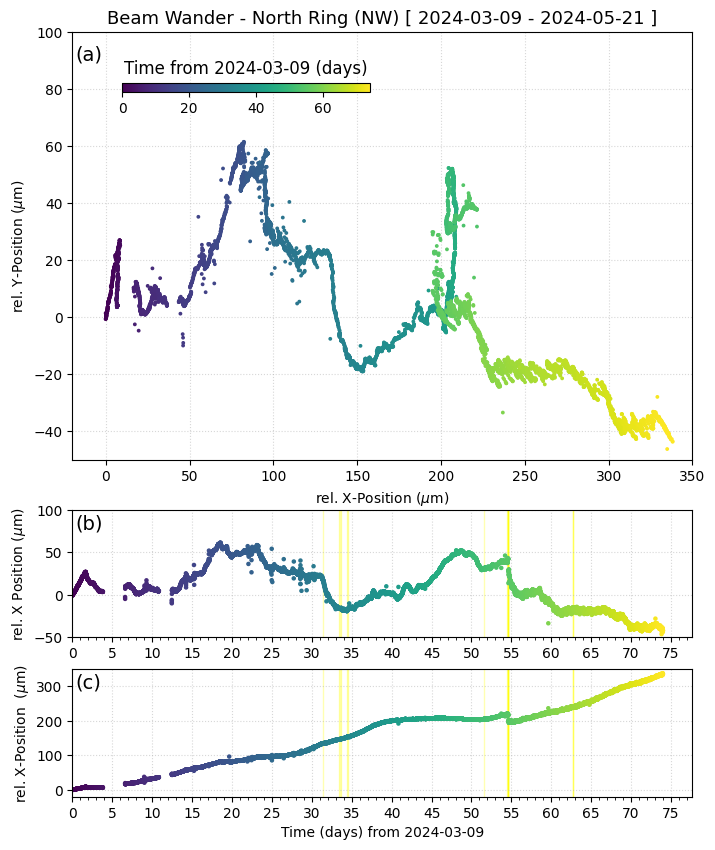

In [16]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    time_scaling = 1/86400

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    # ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # cb = ax1.scatter(df0.x, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    # ax2.scatter(df0.time_sec*time_scaling, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # ax3.scatter(df0.time_sec*time_scaling, df0.x, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("rel. Y-Position ($\mu$m)")
    ax1.set_xlabel("rel. X-Position ($\mu$m)")

    ax2.set_ylabel("rel. X Position ($\mu$m)")
    # ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("rel. X-Position  ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    for ax in [ax2, ax3]:
        ax.set_xlim(left=0)
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

    # x1, x2 = 3.44, 3.52
    # y1, y2 = 1.62, 1.66
    x1, x2 = -20, 350
    y1, y2 = -50, 100
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander - North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.08, 0.86, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)

    # add maintencane periods
    ref_date = config['date1']
    for ax in [ax2, ax3]:
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax.fill_betweenx([-1000, 1000], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.3)

    axes = [ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

# fig.savefig(config['path_to_figures']+f"BW_RU_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')


### Load FFBI Data

In [18]:
from functions.read_sds import __read_sds

In [21]:
ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['date1'], config['date2'])

In [77]:
# opath = data_path+"manuscripts/manuscript_romy_drifts/data/"
# ffbi.write(opath+f"bw_ru_longterm_ffbi.mseed", "MSEED")

In [35]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['date1'], config['date2'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['date1'], config['date2'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['date1'], config['date2'])

ps

3 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-03-09T00:00:00.000000Z - 2024-05-21T00:00:00.000000Z | 1.0 Hz, 6307201 samples
BW.PROMY.05.LKI | 2024-03-09T00:00:00.000000Z - 2024-05-21T00:00:00.000000Z | 1.0 Hz, 6307201 samples
BW.PROMY.09.LKI | 2024-03-09T00:00:00.000000Z - 2024-05-21T00:00:00.000000Z | 1.0 Hz, 6307201 samples

In [78]:
# opath = data_path+"manuscripts/manuscript_romy_drifts/data/"
# ps.write(opath+f"bw_ru_longterm_promy.mseed", "MSEED")

In [58]:
for tr in ps:
    tr.data = __smooth(__reduce(tr.data, 100), 3600)

ps_sum = Stream()
ps_sum = ps[0].copy()

ps_sum.data = np.zeros(len(ps_sum.data))

for tr in ps:
    ps_sum.data += tr.data


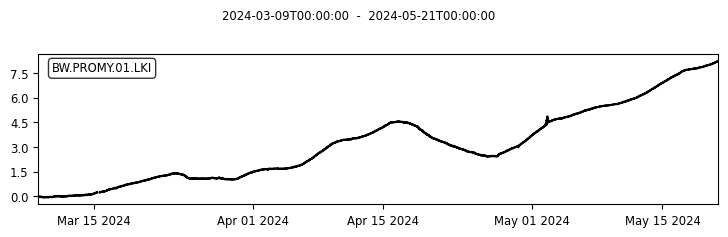

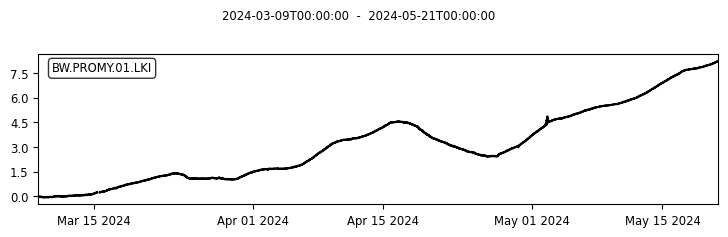

In [60]:
ps_sum.plot()

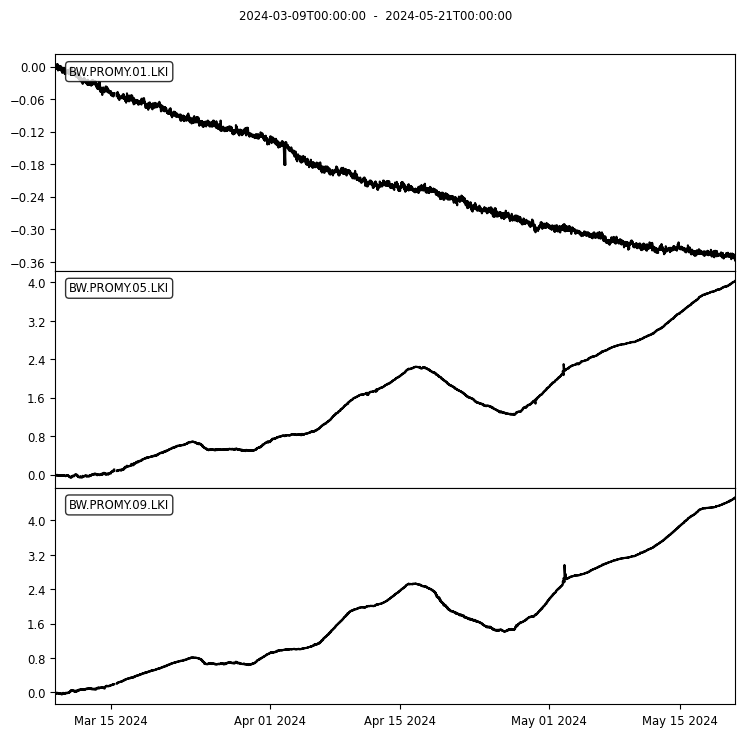

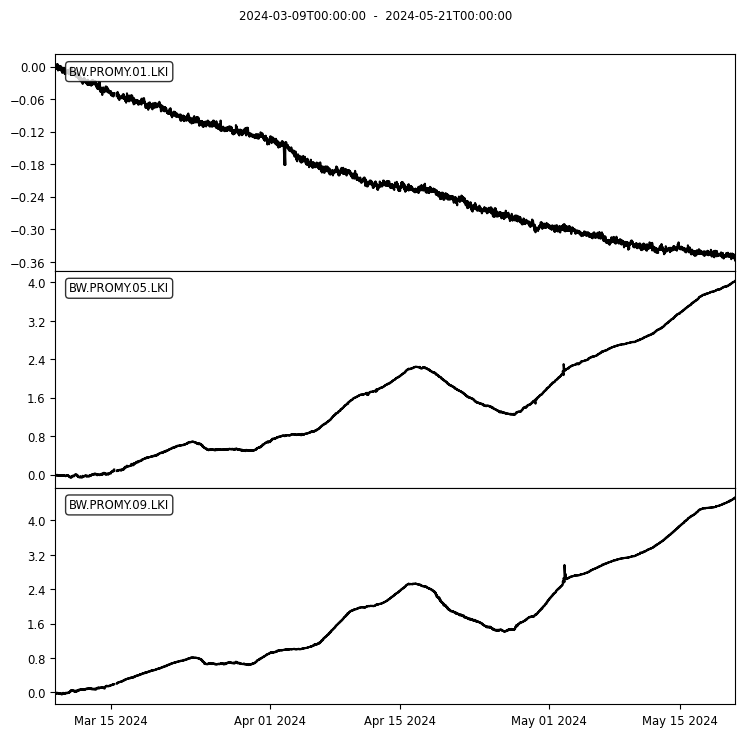

In [72]:
ps.plot(equal_scale=False)

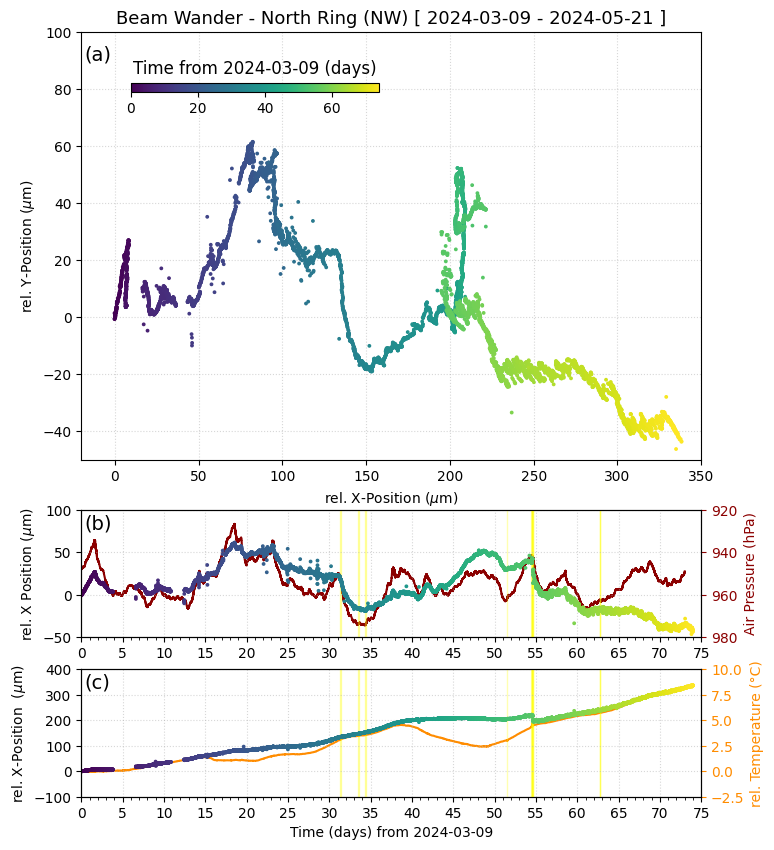

In [70]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    time_scaling = 1/86400

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    # add pressure
    ax222 = ax2.twinx()
    ax222.plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(config['date1']))*time_scaling,
               ffbi.select(channel="*O")[0].data, color="darkred"
              )

    ax222.tick_params(axis='y', colors="darkred")
    ax222.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax222.invert_yaxis()

    ax1.set_ylabel("rel. Y-Position ($\mu$m)")
    ax1.set_xlabel("rel. X-Position ($\mu$m)")

    # add temperature
    ax333 = ax3.twinx()
    ax333.plot(ps_sum.times(reftime=UTCDateTime(config['date1']))*time_scaling,
               ps_sum.data, color="darkorange"
              )

    ax333.tick_params(axis='y', colors="darkorange")
    ax333.set_ylabel("rel. Temperature (°C)", color="darkorange")

    # _________________________________________________________

    ax2.set_ylabel("rel. X Position ($\mu$m)")
    ax3.set_ylabel("rel. X-Position  ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    for ax in [ax2, ax3]:
        ax.set_xlim(0, 75)
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

    # x1, x2 = 3.44, 3.52
    # y1, y2 = 1.62, 1.66
    x1, x2 = -20, 350
    y1, y2 = -50, 100
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
    ax222.set_yticks(np.linspace(ax222.get_yticks()[0], ax222.get_yticks()[-1], len(ax2.get_yticks())))
    ax2.set_zorder(10)
    ax2.patch.set_visible(False)

    ax3.set_yticks(np.linspace(ax3.get_yticks()[0], ax3.get_yticks()[-1], len(ax3.get_yticks())))
    ax333.set_yticks(np.linspace(ax333.get_yticks()[0], ax333.get_yticks()[-1], len(ax3.get_yticks())))
    ax3.set_zorder(10)
    ax3.patch.set_visible(False)

    # add title
    ax1.set_title(f"Beam Wander - North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.08, 0.86, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)

    # add maintencane periods
    ref_date = config['date1']
    for ax in [ax2, ax3]:
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax.fill_betweenx([-1000, 1000], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.3)

    # add subplot labels
    axes = [ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BW_RU_environmentals_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')
